# Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "none" 

In [4]:
# We load in our key by placing it in ~/.openml/config

## Kernel selection (4 points (1+2+1))
SVMs can be trained with different kernels. Generate a 2-dimensional dataset as shown below and study the effect of the choice of kernel by visualizing the results.

- Train a SVM classifier on the dataset using respectively a linear, polynomial and radial basis function (RBF) kernel, evaluate the performance of each kernel using 10-fold cross-validation and AUC. Which one works best? Visualize the results. Can you intuitively explain why one kernel is more suited than another?
    - Hint: you can use the visualization code used in class. It is under mglearn/plot_svm.py > plot_svm_kernels().
- Take the RBF kernel and vary both the C parameter and the kernel width ($\gamma$). Use 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. 
    - Hint: don't count the support vectors manually, retrieve them from the trained SVM.
- Vary C and $\gamma$ again, but this time use a grid of at least 20x20, vary both parameters uniformly on a log scale, and visualise the results using a $C \times \gamma \rightarrow AUC$ heatmap. Explain the performance results, and compare them to the 9 results obtained in the previous subquestion. Can you also tell in which regions of the heatmap you are over/underfitting?
    - Hint: We've constructed such a heatmap in class and in assignment 1.

In [ ]:
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)

## Robots and SVMs (4 points (2+1+1))

The [Wall Robot Navigation dataset](http://www.openml.org/d/1497) contains about 5500 readings of an ultrasound sensor array mounted on a robot, and your task is to finetune and train an SVM classifier to predict how the robot should move next.

- Make a stratified 80-20 split of the data. On the training set alone, optimize the main hyperparameters of the SVM for Accuracy with a random search. Vary at least the main kernel types (linear, polynomial, and RBF), the C parameter, the $\gamma$ parameter for the RBF kernel and the exponent/degree for the polynomial kernel. Report the optimal hyperparameter settings and Accuracy performance. 
    - The degree of the polynonial is typically in the range 2..10.
    - Hint: note that the hyperparameter ranges depend on each other. For instance, $\gamma$ only makes sense if you have selected the RBF kernel as well. We've seen in class how to define multiple hyperparameter spaces in a random/grid search.
- Use a 5x3-fold (5 outer, 3 inner) nested cross-validation (CV) on the training set to obtain a clean evaluation. Evaluate your optimized hyperparameter settings on the separate test set and discuss the result. Is the performance on the independent test set comparable with the result of the random search?
    - Hint: for the nested resampling, use at least a 10-fold CV for the outer loop. The inner loop can be a 3-fold CV or a simple holdout.
- Train an SVM using the optimal hyperparameter configuration you found and test it on the held out (20%) test set. Compare this Accuracy result with the (mean) result of the nested CV. If you would build this robot in practice, how would you find the hyperparameters to use, and which performance would you expect? Is it truly necessary to tune the hyperparameters? Which hyperparameters were most important to tune?

In [4]:
robot_data = oml.datasets.get_dataset(1497) # Download Robot data
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute); 

## A benchmark study (3 points (2+1))

A benchmark study is an experiment in which multiple algorithms are evaluated on multiple datasets. The end goal is to study whether one algorithm is generally better than the others. Meaningful benchmark studies can grow quite complex, here we do a simplified variant.

* Download OpenML datasets 37, 470, 1120, 1464 and 1471. They are sufficiently large (e.g., at least 500 data points) so that the performance estimation is trustworthy. Select at least three classifiers that we discussed in class, e.g. kNN, Logistic Regression, Random Forests, Gradient Boosting, SVMs, Naive Bayes. Note that some of these algorithms take longer to train. Evaluate all classifiers (with default parameter settings) on all datasets, using a 10-fold CV and AUC. Show the results in a table and interpret them. Which is the best algorithm in this benchmark?
    * Note that these datasets have categorical features, different scales, missing values, and (likely) irrelevant features. You'll need to build pipelines to correctly build all models. Also remove any row identifiers (see, e.g., https://www.openml.org/d/1120)
    * Hint: You can either compare the performances directly, or (better) use a statistical significance test, e.g. a pairwise t-test or (better) Wilcoxon signed ranks test, to see whether the performance differences are significant. This is covered in statistics courses. You can then count wins, ties and losses.
* Repeat the benchmark, but now additionally optimize the main hyperparameters of each algorithm in a grid or random search (explore at least 5 values per hyperparameter, where possible). Does this affect the ranking of the algorithms?

In [ ]:
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define datasets and base classifiers
datasets = [37, 470, 1120, 1464, 1471]

# Create kf
kf = StratifiedKFold(n_splits=10, random_state=2)

# Create imputer to pre-process data
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

# Create scaler for the classifiers which need this
scaler = StandardScaler()

pipelines = [
    Pipeline([("imputer",imp), ("scaler", scaler), ("classifier", neighbors.KNeighborsClassifier())]),
    Pipeline([("imputer",imp), ("scaler", scaler), ("classifier", LogisticRegression())]),
    Pipeline([("imputer",imp), ("classifier", RandomForestClassifier())])
]

# Define parameter grids for the classifiers
param_grids = [
    {'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 33]}, 
    {'classifier__C': [0.001, 0.01, 1, 10, 100, 1000] },
    {'classifier__max_features': list(range(1,5)), 'classifier__n_estimators': [1, 2, 4, 8, 16, 32, 64]}
]

# Score dicts
dsScores = {}
dsGridScores = {}

# Process each dataset
for dindex in datasets:
    # Load data
    data_set = oml.datasets.get_dataset(dindex)
    X, y = data_set.get_data(target=data_set.default_target_attribute)
    
    scores = {}
    gridScores = {}
    # Run each clf using the corresponding parameter grid
    for pipe, grid in zip(pipelines, param_grids):
        # Run 10-fold pipeline
        score = cross_val_score(pipe, X, y, cv=kf, n_jobs=8, scoring="roc_auc").mean()
        scores[clf.__class__.__name__] = score;

        # Run gridsearch pipeline
        gs = GridSearchCV(pipe, grid, cv=kf, n_jobs=8)
        gs.fit(X, y)
        results = pd.DataFrame(gs.cv_results_)
        gridScores[clf.__class__.__name__] = gs.best_score_

    dsScores[dindex] = scores
    dsGridScores[dindex] = gridScores

# Print default classifier scores
print("Default scores:")
print(pd.DataFrame.from_dict(dsScores))

# Print best grid scores
print("\nOptimized grid scores:")
print(pd.DataFrame.from_dict(dsGridScores))

## Gaussian Processes (2 points (1+1))

Consider the RAM prices dataset (included in the data folder). Separate the data in a training set of all data points up until the year 2000, and a test set with all points after that.

- Train several of the algorithms we have covered in the course that can handle regression. Include at least linear regression, decision tree, and RandomForest. Which ones give the best $R^2$ performance on the test set? Plot the predictions (both on the training and test data) on the figure below. Use different colors for different algorithms or build multiple plots.
- Train a Gaussian process on an increasing amount of samples of the training data. Start with 5 random sample and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Now add 5 more points and retrain and redraw. Do this a couple of times and interpret/explain what you see. Finally, train the Gaussian on the full dataset and again show plot the predictions. Evaluate on the test set using  $R^2$. Compare these results with those achieved with other algorithms and explain.

<bound method NDFrame.as_matrix of 0      1957.00
1      1959.00
2      1960.00
3      1965.00
4      1970.00
5      1973.00
6      1974.00
7      1975.00
8      1975.08
9      1975.25
10     1975.75
11     1976.00
12     1976.17
13     1976.42
14     1976.58
15     1977.08
16     1978.17
17     1978.25
18     1978.33
19     1978.50
20     1978.58
21     1978.75
22     1979.00
23     1979.75
24     1980.00
25     1981.00
26     1981.58
27     1982.00
28     1982.17
29     1982.67
        ...   
172    1997.25
173    1997.33
174    1997.42
175    1997.50
176    1997.58
177    1997.67
178    1997.75
179    1997.83
180    1997.92
181    1998.00
182    1998.08
183    1998.17
184    1998.25
185    1998.33
186    1998.42
187    1998.58
188    1998.67
189    1998.75
190    1998.83
191    1998.92
192    1999.08
193    1999.13
194    1999.17
195    1999.25
196    1999.33
197    1999.50
198    1999.67
199    1999.75
200    1999.83
201    1999.92
Name: date, dtype: float64>


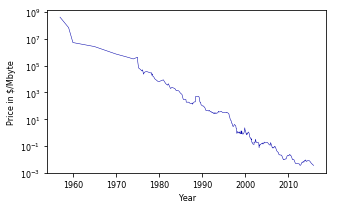

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

ram_prices = pd.read_csv('data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

train = ram_prices.query("date < 2000")
test = ram_prices.query("date >= 2000")

print (train.date.array)
algorithms = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor()]

# for alg in algorithms:
#     alg.fit(train.date, train.price)
#     print(alg.score(test.date, test.price))
#     print(cross_val_score(alg, ram_prices.date, ram_prices.price, cv=10, scoring="r2").mean())
   

## A mini-data mining challenge (2 points (+1))

The goal here is to use everything you have learned to build the best model for a given classification task. The task is hosted on OpenML, so you will receive the train-test splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial.

- All details can be found online:
    - The OpenML Task ID is 145677: https://www.openml.org/t/145677
    - The dataset description can be found here: https://www.openml.org/d/4134
- A leaderboard is kept of the best models: https://www.openml.org/t/145677#!people
    - You are able to see the solutions of others (by clicking in the timeline or run list), but resubmission of the exact same solution does not register on the leaderboard.
    - You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- You can document the different experiments that you ran in this notebook. For each experiment, provide a description of how you chose the algorithms and parameters that you submitted. Try to reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows:
    - 1 point for the breadth of experiments you ran (algorithms, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the table.
        
Note: Report AUC scores in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.

In [7]:
import openml as oml

# Load task data
task = oml.tasks.get_task(145677)
data = oml.datasets.get_dataset(task.dataset_id)
X, y = data.get_data(target=data.default_target_attribute)

We have lots of features (1777) Hence, we should either figure something out to reduce the amount features, or use a classifier which handles a lot of features well. Initially, our thoughts fell on using a random forest classifier without selecting features (this is what the decision trees do themselves anyhow).

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# We don't need a scalar since the dataset is already normalized

# Create classifier
clf = RandomForestClassifier(random_state=1, n_estimators=2048, min_samples_split=4, criterion="entropy", n_jobs=-1)

# Build pipeline
pipe = Pipeline([
    ('classifier', clf)
])

task = oml.tasks.get_task(145677)
print("Running..")
run = oml.runs.run_task(task, pipe)
print("Publishing run")
myrun = run.publish()
print("RF on %s: http://www.openml.org/r/%d" % (data.name, myrun.run_id))

Running..
Publishing run
RF on Bioresponse: http://www.openml.org/r/1849099


This result was decent, but we did not find any way to significantly improve this. Hence, we now attempted to use logistic regression. But we still wanted to keep the performance from the RandomForest classifier. Hence we used this as the feature selector before we ran the LogisticRegression.

In [25]:
from sklearn.svm import SVC

# Create feature selector 
fs = SelectFromModel(RandomForestClassifier(random_state=1, criterion="entropy"))

# Create default classifier
clf = SVC()

pipe = Pipeline([
    ('feature_select', fs),
    ('classifier', clf)
])

grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__kernel": ["linear", "poly", "rbf"],
    "classifier__gamma": [0.01, 0.1, 1, 10, 100]
}
gs = GridSearchCV(pipe, grid, cv=10, n_jobs=-1, scoring="roc_auc", verbose=1)
gs.fit(X, y)

print(gs.best_score_)     
print(gs.best_params_)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 43.9min finished


0.859742509623
{'classifier__gamma': 0.01, 'classifier__C': 10, 'classifier__kernel': 'rbf'}


The results from this classification where significantly higher then we expected.
Therefore we attempted to improve the best results further by increasing the number of estimators of the random forest classifier. And to optimize only the rbf kernel further.

In [34]:
# Create feature selector 
fs = SelectFromModel(RandomForestClassifier(random_state=1, n_estimators=256, criterion="entropy"))

# Create default classifier
clf = SVC(kernel="rbf", C=10, gamma=0.01)

pipe = Pipeline([
    ('feature_select', fs),
    ('classifier', clf)
])

task = oml.tasks.get_task(145677)
print("Running..")
run = oml.runs.run_task(task, pipe)
print("Publishing run")
myrun = run.publish()
print("SVM on %s: http://www.openml.org/r/%d" % (data.name, myrun.run_id))

Running..
Publishing run
RF on Bioresponse: http://www.openml.org/r/1849100
